<a href="https://colab.research.google.com/github/Mhtag/tensorflow/blob/main/11_tensorflowhub_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).


In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import pandas as pd


# Part 1: Use a TensorFlow Hub MobileNet for prediction

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

## Download the classifier

MobileNet is expecting the image of 224 $\times$ 224 pixels, in 3 color channel (RGB).

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
                             hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES,3))
])


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


## RUN it on single image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

73728/61306 [====================================] - 0s 0us/step


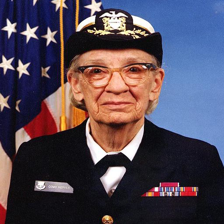

In [4]:
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [6]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape,result

((1, 1001), array([[ 0.19971359,  1.0666462 , -0.10109375, ...,  0.15688017,
         -0.60558677, -0.04497072]], dtype=float32))

The result is 1001 element vector of logits, rating the probabilty of each class of image.

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the prediction

24576/10484 [======================================================================] - 0s 0us/step


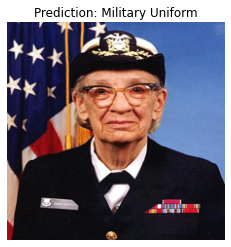

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: use a tensorflowhub model for cats and dogs dataset

## Dataset

In [9]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]']
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7V77AV/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [10]:
num_examples, num_classes

(23262, 2)

the images in cats vs dogs are not of same size

In [11]:
for i, example_image in enumerate(train_examples.take(6)):
  print(f'image {i+1} shape {example_image[0].shape} ')

image 1 shape (262, 350, 3) 
image 2 shape (409, 336, 3) 
image 3 shape (493, 500, 3) 
image 4 shape (375, 500, 3) 
image 5 shape (240, 320, 3) 
image 6 shape (100, 100, 3) 


So we need to reformat all images as expected by MobileNet ie. 224 $\times$ 224.

In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (224,224))/255.0
  return image, label



In [13]:
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(32).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(32).prefetch(1)

Most dataset input pipelines should end with a call to **prefetch**. This allows later elements to be prepared while the current element is being processed. This often **improves latency** and throughput, at the cost of using additional memory to store prefetched elements.

examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each)

## Run the classifier on a batch of images

Remember our model object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes. ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

In [15]:
predicted_class_names

array(['Persian cat', 'carton', 'boxer', 'Labrador retriever',
       'Egyptian cat', 'black-and-tan coonhound', 'tabby', 'crib',
       'Egyptian cat', 'Egyptian cat', 'Dandie Dinmont', 'Chihuahua',
       'Egyptian cat', 'Walker hound', 'toilet tissue', 'tiger cat',
       'Persian cat', 'Tibetan mastiff', 'tiger cat', 'Egyptian cat',
       'Staffordshire bullterrier', 'German short-haired pointer',
       'tabby', 'Persian cat', 'Labrador retriever', 'Siamese cat',
       'English setter', 'chow', 'Persian cat', 'Siamese cat', 'tabby',
       'miniature schnauzer'], dtype='<U30')

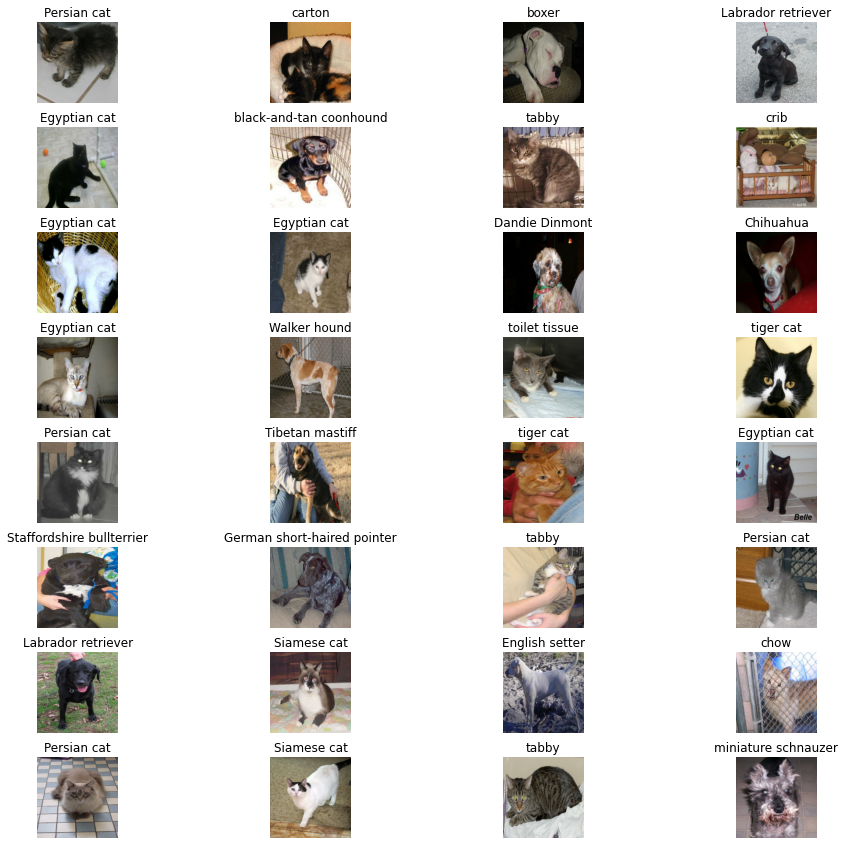

In [16]:
plt.figure(figsize=(16,15))
for n in range(32):
  plt.subplot(8,4,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
plt.show()


In [17]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(224,224,3))

In [18]:
feature_batch = feature_extractor(image_batch)
print(feature_extractor)

In [19]:
feature_extractor.trainable = False

In [20]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 64s 96ms/step - loss: 0.0597 - accuracy: 0.9792 - val_loss: 0.0334 - val_accuracy: 0.9886
Epoch 2/10
582/582 [==============================] - 59s 93ms/step - loss: 0.0307 - accuracy: 0.9898 - val_loss: 0.0371 - val_accuracy: 0.9877
Epoch 3/10
582/582 [==============================] - 59s 93ms/step - loss: 0.0255 - accuracy: 0.9917 - val_loss: 0.0307 - val_accuracy: 0.9905
Epoch 4/10
582/582 [==============================] - 59s 93ms/step - loss: 0.0217 - accuracy: 0.9923 - val_loss: 0.0300 - val_accuracy: 0.9899
Epoch 5/10
582/582 [==============================] - 59s 93ms/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.0313 - val_accuracy: 0.9908
Epoch 6/10
582/582 [==============================] - 59s 93ms/step - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.0340 - val_accuracy: 0.9888
Epoch 7/10
582/582 [==============================] - 59s 94ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0333 - val_accuracy:

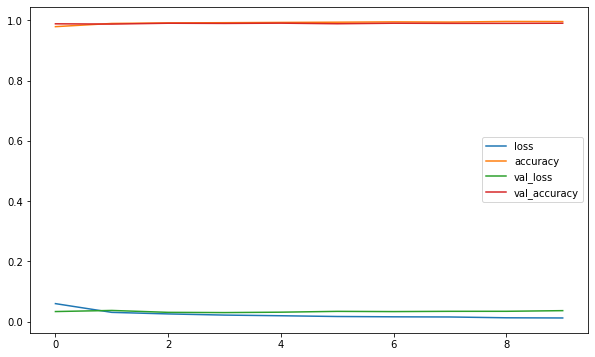

In [23]:
import pandas as pd
df=pd.DataFrame(history.history.values()).T
df.columns = history.history.keys()
df.plot(figsize=(10,6))